# Facebook prophet model #####

In [33]:
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go
import utils
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Import the data 
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path, parse_dates=['date'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.set_index('date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [35]:
# Import the data
df = load_and_prepare_data('../../data/Final_data/final_data.csv')

# Reset the index
df = df.reset_index()

# rename date and Day_ahead_price columns to ds and y
df = df.rename(columns={'date': 'ds', 'Day_ahead_price': 'y'})

In [36]:
def train_test_split_sequential(data, test_size=0.2):
    """
    Split the sequence data into training and testing datasets sequentially.
    
    Parameters:
    - data: List of tuples where each tuple contains (sequence, label).
    - test_size: Fraction of the dataset to be used as test data.

    Returns:
    - train_data: Training data containing sequences and labels.
    - test_data: Testing data containing sequences and labels.
    """
    split_idx = int(len(data) * (1 - test_size))  # Calculate split index
    train_data = data[:split_idx]
    test_data = data[split_idx:]
    return train_data, test_data

train_df, test_df= train_test_split_sequential(df, test_size=0.2)

In [37]:
test_df

,ds,y,BEV_vehicles,Biomass (GWh),Hard Coal (GWh),Hydro (GWh),Lignite (GWh),Natural Gas (GWh),Nuclear (GWh),Oil_price (EUR),Other (GWh),Pumped storage generation (GWh),Solar (GWh),Solar_radiation,TTF_gas_price (EUR/MWh),Temperature,Wind offshore (GWh),Wind onshore (GWh),Wind_speed,net_total_export_import (GWh)
3551,2021-09-25,127.5875,1121,108.415,186.286,41.011,295.871,160.924,155.310,71.20,72.172,15.988,162.153,137.79,72.1650,15.85,30.353,130.091,2.45,65.105
3552,2021-09-26,125.7175,1121,107.432,153.449,38.331,329.843,127.387,156.181,71.61,70.080,8.484,144.795,122.88,74.0725,17.19,26.765,100.860,2.39,62.815
3553,2021-09-27,143.2183,1121,106.826,211.583,42.679,354.788,202.210,154.868,72.03,75.899,14.948,118.205,102.75,75.9800,16.50,83.014,159.210,2.73,26.815
3554,2021-09-28,155.0863,1121,107.642,239.115,43.670,354.952,232.155,157.304,71.93,76.988,19.313,127.473,113.67,79.0000,13.21,45.002,88.953,2.33,-28.088
3555,2021-09-29,133.3138,1121,108.355,174.489,43.589,337.405,140.357,155.106,71.38,75.426,13.621,100.594,82.54,80.0000,11.95,113.690,342.545,3.83,78.594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4434,2024-02-25,61.0938,947,123.683,48.501,58.671,193.697,255.124,0.000,74.73,60.627,13.565,169.216,97.58,23.7625,4.52,29.879,278.787,3.43,-36.930
4435,2024-02-26,66.2683,947,124.810,69.146,58.444,281.177,289.764,0.000,74.60,59.810,12.231,110.504,73.25,23.9000,4.96,62.336,239.555,3.12,-198.686
4436,2024-02-27,73.8362,947,124.989,103.379,59.181,351.355,354.042,0.000,75.61,67.170,23.753,85.584,58.12,24.8300,4.53,16.951,131.761,3.11,-209.332
4437,2024-02-28,71.8213,947,125.068,93.416,58.160,350.348,338.216,0.000,76.07,65.375,19.042,106.330,66.00,24.8000,3.69,68.585,76.355,2.46,-206.956


In [38]:
# Create the prophet model
m = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=10,
    weekly_seasonality=3,
    daily_seasonality=False
)
# Add monthly seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_country_holidays(country_name='DE')


# Add regressors for all columns except ds and y
for column in df.columns:
    if column not in ['ds', 'y']:
        m.add_regressor(column)

m.fit(train_df)
# Print out the holidays that have been added to the model
print(m.train_holiday_names)

14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:26 - cmdstanpy - INFO - Chain [1] done processing


0             New Year's Day
1                Good Friday
2              Easter Monday
3                  Labor Day
4              Ascension Day
5                Whit Monday
6           German Unity Day
7              Christmas Day
8    Second Day of Christmas
9            Reformation Day
dtype: object


In [39]:
future = m.make_future_dataframe(periods=test_df.shape[0], freq='1D')

# Check the alignment and number of rows
print(future['ds'].equals(df['ds']))  # Should return True if perfectly aligned
print(future.shape[0] == df.shape[0])  # Also should return True


True
True


In [40]:
# Add columns from df to future
for column in df.columns:
    if column != 'ds':  # Assuming 'ds' is already in future
        future[column] = df[column]

forecast = m.predict(future)

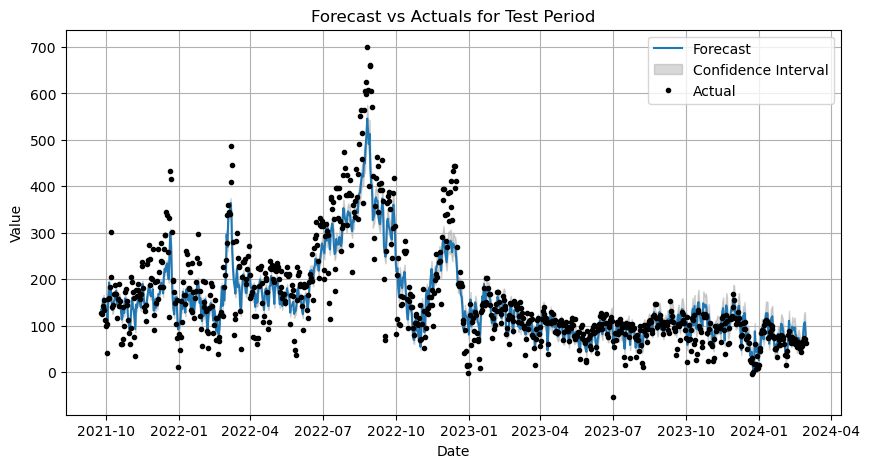

In [41]:
# Define the test period start and end dates
test_start = test_df['ds'].min()
test_end = test_df['ds'].max()

# Filter forecast to test period
test_forecast = forecast[(forecast['ds'] >= test_start) & (forecast['ds'] <= test_end)]

# Filter historical data to test period
test_actuals = df[(df['ds'] >= test_start) & (df['ds'] <= test_end)]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Forecast')
plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'], color='gray', alpha=0.3, label='Confidence Interval')
plt.plot(test_actuals['ds'], test_actuals['y'], 'k.', label='Actual')
plt.title('Forecast vs Actuals for Test Period')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
# Example: Plotting a subset or a smoothed version of the forecast
forecast_subset = forecast.set_index('ds').resample('W').mean().reset_index()  # Resampling weekly
#fig2 = m.plot_components(forecast_subset)


In [43]:
# Python
plot_components_plotly(m, forecast)

In [44]:
verif = utils.make_verif(forecast, train_df, test_df)

In [45]:
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ascension Day,Ascension Day_lower,Ascension Day_upper,BEV_vehicles,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2012-01-01,2012-01-01,35.759621,6.562933,21.348575,35.759621,35.759621,0.0,0.0,0.0,0.005932,...,-0.169212,-0.169212,-0.089711,-0.089711,-0.089711,0.0,0.0,0.0,14.599067,18.1896
2012-01-02,2012-01-02,35.748246,30.080175,44.173991,35.748246,35.748246,0.0,0.0,0.0,0.005932,...,0.032358,0.032358,-0.086527,-0.086527,-0.086527,0.0,0.0,0.0,37.250554,33.8188
2012-01-03,2012-01-03,35.736872,20.062728,34.672775,35.736872,35.736872,0.0,0.0,0.0,0.005932,...,0.044408,0.044408,-0.082870,-0.082870,-0.082870,0.0,0.0,0.0,27.093477,35.0263
2012-01-04,2012-01-04,35.725497,20.759466,35.707122,35.725497,35.725497,0.0,0.0,0.0,0.005932,...,0.053768,0.053768,-0.078795,-0.078795,-0.078795,0.0,0.0,0.0,28.228869,32.1633
2012-01-05,2012-01-05,35.714123,16.492725,31.180817,35.714123,35.714123,0.0,0.0,0.0,0.005932,...,0.051583,0.051583,-0.074366,-0.074366,-0.074366,0.0,0.0,0.0,24.026008,20.3500


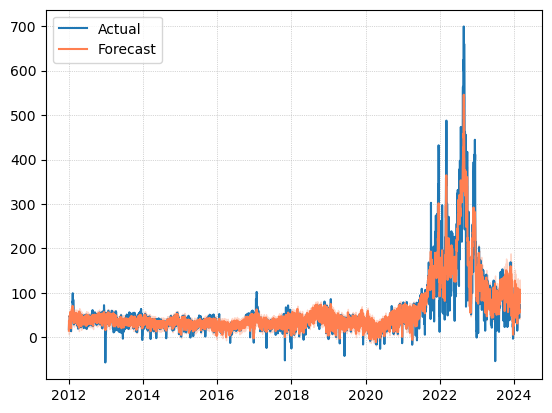

In [60]:
def plot_verif(verif, year=None):
    f, ax = plt.subplots()
    ax.plot(verif['ds'], verif['y'], label='Actual')
    ax.plot(verif['ds'], verif['yhat'], label='Forecast', color='coral')
    ax.fill_between(verif['ds'], verif['yhat_lower'], verif['yhat_upper'], color='coral', alpha=0.3)

    if year is not None:
        year_datetime = datetime.datetime(year=int(year), month=1, day=1)
        ax.axvline(year_datetime, color='0.8', alpha=0.7)

    ax.grid(ls=':', lw=0.5)
    ax.legend()
    # Only call plt.show() and do not return the figure
    plt.show()

# Now calling the function
plot_verif(verif)


In [47]:
# Assuming 'test_df' contains the actual values in 'y' and 'forecast' contains the predicted values in 'yhat'
# First, ensure that your test_df and forecast are aligned by date and filter the forecast to the test period
test_forecast = forecast[(forecast['ds'] >= test_df['ds'].min()) & (forecast['ds'] <= test_df['ds'].max())]

# Make sure the lengths are the same and they are in the same order
if len(test_forecast) == len(test_df) and all(test_forecast['ds'].values == test_df['ds'].values):
    mse = np.mean((test_forecast['yhat'] - test_df['y']) ** 2)
    mae = np.mean(np.abs(test_forecast['yhat'] - test_df['y']))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_forecast['yhat'] - test_df['y']) / test_df['y'])) * 100  # Multiply by 100 to get percentage

    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}%')
else:
    print("The forecast and actual data do not align correctly. Please check the data.")


MSE: 2109.3525186548322
MAE: 31.13712541170934
RMSE: 45.927687930646286
MAPE: 45.00651399386525%


In [48]:
# Handling potential division by zero in MAPE calculation
non_zero_mask = test_df['y'] != 0
if np.any(non_zero_mask):
    mape = np.mean(np.abs((test_forecast['yhat'][non_zero_mask] - test_df['y'][non_zero_mask]) / test_df['y'][non_zero_mask])) * 100
    print(f'MAPE: {mape}%')
else:
    print("MAPE calculation skipped due to zero actual values.")


MAPE: 45.00651399386525%


In [49]:
evaluation_metrics = {
    'MSE': mse,
    'MAE': mae,
    'RMSE': rmse,
    'MAPE': mape
}

# Convert to DataFrame for easy viewing/exporting
import pandas as pd
metrics_df = pd.DataFrame([evaluation_metrics])
print(metrics_df)


           MSE        MAE       RMSE       MAPE
0  2109.352519  31.137125  45.927688  45.006514


In [52]:
from prophet.utilities import regressor_coefficients

# Assuming 'm' is the Prophet model and 'train_df' is the DataFrame used for training
coefficients = regressor_coefficients(m)
print(coefficients)

                          regressor  regressor_mode      center  coef_lower  \
0                      BEV_vehicles  multiplicative  166.072092   -0.000037   
1                     Biomass (GWh)  multiplicative  118.673371    0.000249   
2                   Hard Coal (GWh)  multiplicative  233.336564    0.000881   
3                       Hydro (GWh)  multiplicative   54.102830   -0.001452   
4                     Lignite (GWh)  multiplicative  351.082655    0.000180   
5                 Natural Gas (GWh)  multiplicative  209.264213    0.000210   
6                     Nuclear (GWh)  multiplicative  216.970264    0.000256   
7                   Oil_price (EUR)  multiplicative   65.588854    0.002385   
8                       Other (GWh)  multiplicative   60.911058    0.002870   
9   Pumped storage generation (GWh)  multiplicative   21.321836    0.001121   
10                      Solar (GWh)  multiplicative  110.368485   -0.000353   
11                  Solar_radiation  multiplicative 

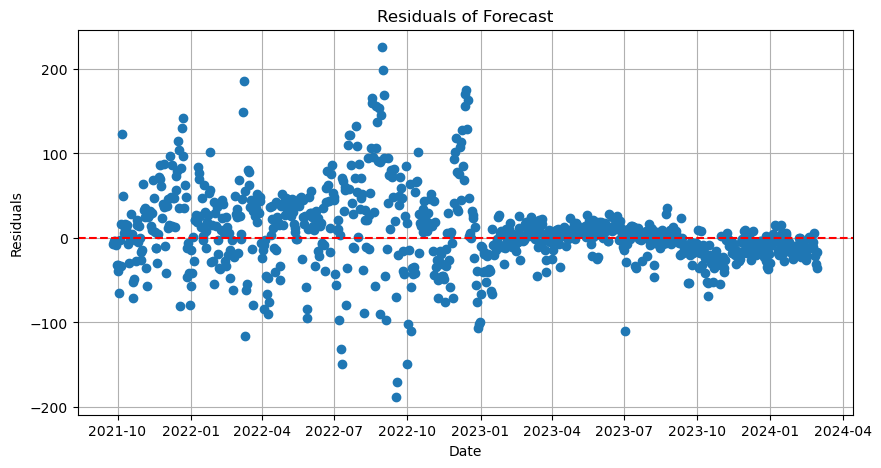

In [50]:
# Plot residuals
residuals = test_df['y'] - test_forecast['yhat']
plt.figure(figsize=(10, 5))
plt.plot(test_df['ds'], residuals, marker='o', linestyle='')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals of Forecast')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()
